In [1]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

In [2]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


      cat      frog     plane       car


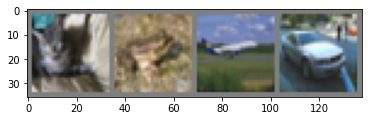

In [5]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Upload the data

In [3]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

In [ ]:
use_spot_instances = True
max_run=600
max_wait = 1200 if use_spot_instances else None

In [ ]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 10}

distribution = {"smdistributed": {"dataparallel": {"enabled": True }}}

spot_estimator = PyTorch(entry_point='cifar10.py',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p3.2xlarge',
                            base_job_name='cifar10-pytorch-spot-1',
                            distribution = distribution,
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)